In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
# from matplotlib import rc
# import matplotlib.font_manager as fm

# fm.get_fontconfig_fonts()

# # 디렉토리 및 파일 이름에 맞추어 변경
# font_location = 'C:/Users/yytt/Desktop/글꼴/나눔고딕/NanumGothic.ttf'

# font_name = fm.FontProperties(fname=font_location).get_name()
# rc('font', family=font_name)

In [3]:
CFG = {
    'IMG_SIZE':224, # fixed
    'EPOCHS':50,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':16,
    'SEED':41
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [5]:
train_df = pd.read_csv('C:/Users/sanda/Desktop/dacon/train_with_img.csv')
test_df = pd.read_csv('C:/Users/sanda/Desktop/dacon/test_with_img.csv')
# train_df = pd.read_csv('C:/Users/sanda/Desktop/dacon/train.csv')
# test_df = pd.read_csv('C:/Users/sanda/Desktop/dacon/test.csv')

In [6]:
train_df['암의 장경'] = train_df['암의 장경'].fillna(train_df['암의 장경'].mean())
train_df = train_df.fillna(0)

test_df['암의 장경'] = test_df['암의 장경'].fillna(train_df['암의 장경'].mean())
test_df = test_df.fillna(0)

In [7]:
train_df.shape

(1000, 29)

In [8]:
test_df.shape

(250, 27)

In [9]:
train_df.nunique()

ID                   1000
img_path             1000
mask_path              59
나이                     62
수술연월일                 821
진단명                     4
암의 위치                   3
암의 개수                   2
암의 장경                  74
NG                      4
HG                      4
HG_score_1              4
HG_score_2              4
HG_score_3              5
DCIS_or_LCIS_여부         3
DCIS_or_LCIS_type       3
T_category              5
ER                      2
ER_Allred_score         7
PR                      2
PR_Allred_score        10
KI-67_LI_percent      358
HER2                    2
HER2_IHC                4
HER2_SISH               2
HER2_SISH_ratio        88
BRCA_mutation           2
N_category              2
img                     2
dtype: int64

In [10]:
train_df.describe()

,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,HG_score_3,...,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category,img
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.679000,1.289000,1.561000,1.133000,18.375564,1.965000,1.734000,2.350000,1.947000,1.301000,...,0.641000,3.309000,13.798480,0.244000,1.223000,0.032000,0.430580,0.008000,0.514000,0.499000
std,11.253471,0.796312,0.559099,0.339745,11.614010,0.813903,0.864865,0.973883,0.880322,0.794374,...,0.479947,3.628317,18.170946,0.429708,0.947718,0.176088,3.226517,0.126301,0.500054,0.500249
min,25.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,1.000000,1.000000,1.000000,11.000000,2.000000,1.000000,2.000000,2.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52.000000,1.000000,2.000000,1.000000,18.000000,2.000000,2.000000,3.000000,2.000000,1.000000,...,1.000000,4.000000,6.190000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,62.000000,1.000000,2.000000,1.000000,22.000000,3.000000,2.000000,3.000000,3.000000,2.000000,...,1.000000,6.000000,20.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,93.000000,4.000000,3.000000,2.000000,110.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,1.000000,54.000000,97.000000,1.000000,3.000000,1.000000,94.000000,2.000000,1.000000,1.000000


In [11]:
train_df.corr()

,나이,진단명,암의 위치,암의 개수,암의 장경,NG,HG,HG_score_1,HG_score_2,HG_score_3,...,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category,img
나이,1.000000,-0.025382,0.030878,-0.111352,0.123889,0.067624,0.043465,0.079494,0.050823,0.008468,...,-0.183525,-0.088546,0.000314,0.012073,0.025021,0.047621,0.020787,-0.008051,0.069017,0.070445
진단명,-0.025382,1.000000,-0.011532,0.090882,0.006558,-0.117202,-0.090298,-0.109908,-0.103787,-0.079104,...,0.030777,0.086856,-0.033021,-0.074643,-0.009878,-0.030325,-0.007744,-0.023011,-0.049135,-0.080941
암의 위치,0.030878,-0.011532,1.000000,0.002039,-0.005519,0.067389,0.068782,0.060024,0.062504,0.079197,...,-0.002242,0.021539,0.040058,-0.016183,-0.013419,0.030991,-0.030583,0.021433,-0.026330,-0.003361
암의 개수,-0.111352,0.090882,0.002039,1.000000,0.011283,0.125451,0.079642,0.131451,0.107264,-0.007540,...,0.041419,0.106298,0.115792,-0.119661,0.025931,0.045913,0.013170,0.021835,0.268900,0.251097
암의 장경,0.123889,0.006558,-0.005519,0.011283,1.000000,0.226823,0.295010,0.162824,0.219179,0.254474,...,-0.098909,-0.059947,0.195349,-0.001702,-0.011857,0.055790,0.154269,-0.012456,0.280664,0.241106
NG,0.067624,-0.117202,0.067389,0.125451,0.226823,1.000000,0.687829,0.525665,0.796537,0.486974,...,-0.211575,-0.070568,0.412314,0.073099,0.106160,0.140527,0.063806,0.022202,0.366439,0.303543
HG,0.043465,-0.090298,0.068782,0.079642,0.295010,0.687829,1.000000,0.778550,0.839999,0.767938,...,-0.288163,-0.203137,0.421725,0.150576,0.094425,0.121677,0.058899,-0.017155,0.348860,0.297847
HG_score_1,0.079494,-0.109908,0.060024,0.131451,0.162824,0.525665,0.778550,1.000000,0.736217,0.513228,...,-0.167793,-0.118455,0.267776,0.087546,0.049835,0.109738,0.030581,-0.039063,0.374301,0.331520
HG_score_2,0.050823,-0.103787,0.062504,0.107264,0.219179,0.796537,0.839999,0.736217,1.000000,0.641211,...,-0.248829,-0.178515,0.390813,0.142714,0.118564,0.133644,0.059714,-0.014189,0.384844,0.326061
HG_score_3,0.008468,-0.079104,0.079197,-0.007540,0.254474,0.486974,0.767938,0.513228,0.641211,1.000000,...,-0.272900,-0.199006,0.396002,0.189310,0.112855,0.045570,0.058549,-0.004071,0.174598,0.150637


<AxesSubplot:>

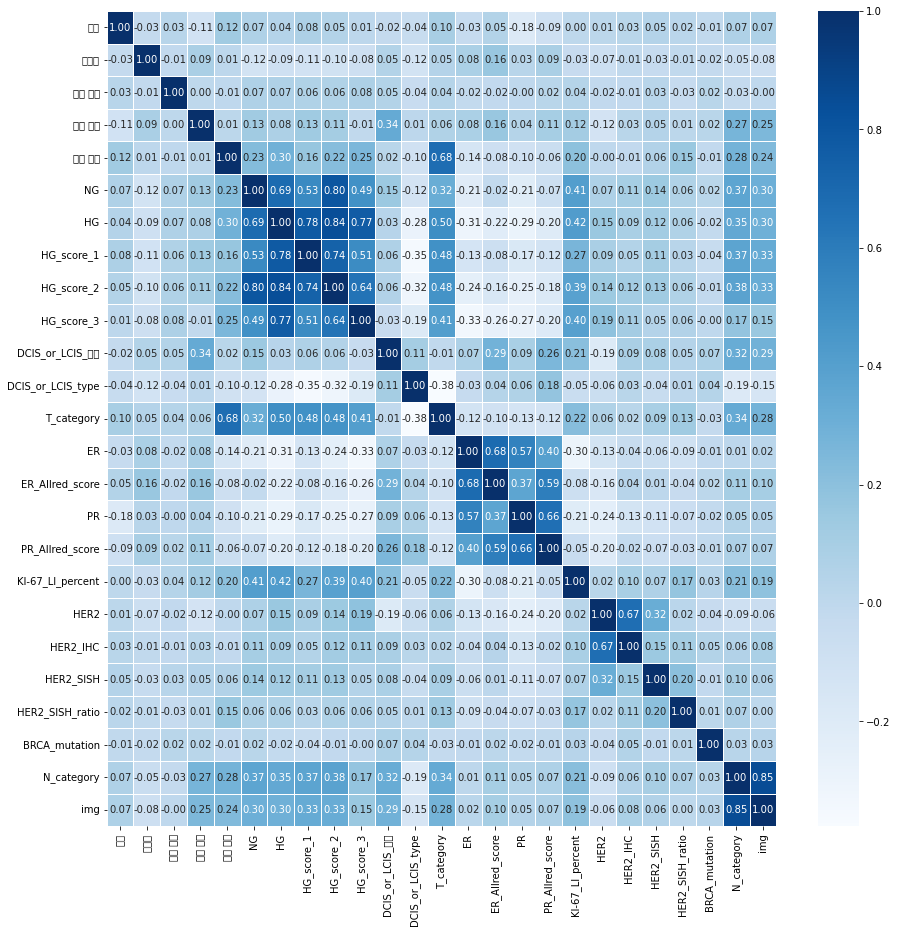

In [12]:
%matplotlib inline  
import matplotlib.pyplot as plt 
import seaborn as sns    


plt.figure(figsize=(15,15))
sns.heatmap(data = train_df.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [13]:
# pr = train_df['img'].tolist()
# la = train_df['N_category'].tolist()

# get_eval(la , pr)

In [14]:
train_df, val_df, train_labels, val_labels = train_test_split(
                                                    train_df.drop(columns=['N_category']), 
                                                    train_df['N_category'], 
                                                    test_size=0.2, 
                                                    random_state=CFG['SEED'],
                                                    stratify=train_df['N_category']
                                                )

In [15]:
train_labels.value_counts()

1    411
0    389
Name: N_category, dtype: int64

In [16]:
val_labels.value_counts()

1    103
0     97
Name: N_category, dtype: int64

In [17]:
train_df = train_df.drop(columns=['ID', 'img_path', 'mask_path', '수술연월일'])
val_df = val_df.drop(columns=['ID', 'img_path', 'mask_path', '수술연월일'])
test_df = test_df.drop(columns=['ID', 'img_path', '수술연월일'])

In [18]:
train_df.columns

Index(['나이', '진단명', '암의 위치', '암의 개수', '암의 장경', 'NG', 'HG', 'HG_score_1',
       'HG_score_2', 'HG_score_3', 'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type',
       'T_category', 'ER', 'ER_Allred_score', 'PR', 'PR_Allred_score',
       'KI-67_LI_percent', 'HER2', 'HER2_IHC', 'HER2_SISH', 'HER2_SISH_ratio',
       'BRCA_mutation', 'img'],
      dtype='object')

In [19]:
test_df.columns

Index(['나이', '진단명', '암의 위치', '암의 개수', '암의 장경', 'NG', 'HG', 'HG_score_1',
       'HG_score_2', 'HG_score_3', 'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type',
       'T_category', 'ER', 'ER_Allred_score', 'PR', 'PR_Allred_score',
       'KI-67_LI_percent', 'HER2', 'HER2_IHC', 'HER2_SISH', 'HER2_SISH_ratio',
       'BRCA_mutation', 'img'],
      dtype='object')

In [20]:
def get_values(value):
    return value.values.reshape(-1, 1)

numeric_cols = ['나이', '암의 장경', 'ER_Allred_score', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2_SISH_ratio']
ignore_cols = ['ID', 'img_path', 'mask_path', '수술연월일', 'N_category']

for col in train_df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        scaler = StandardScaler()
        train_df[col] = scaler.fit_transform(get_values(train_df[col]))
        val_df[col] = scaler.transform(get_values(val_df[col]))
        test_df[col] = scaler.transform(get_values(test_df[col]))
    else:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(get_values(train_df[col]))
        val_df[col] = le.transform(get_values(val_df[col]))
        test_df[col] = le.transform(get_values(test_df[col]))

In [21]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix

In [22]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix

In [23]:
lgbm_tree =  LGBMClassifier(n_estimators= 400)

evals = [(val_df , val_labels)]

lgbm_tree.fit(train_df,train_labels, early_stopping_rounds =100 , eval_metric='logloss', eval_set= evals , verbose= True)

[1]	valid_0's binary_logloss: 0.67039
[2]	valid_0's binary_logloss: 0.658756
[3]	valid_0's binary_logloss: 0.655133
[4]	valid_0's binary_logloss: 0.657727
[5]	valid_0's binary_logloss: 0.66527
[6]	valid_0's binary_logloss: 0.676829
[7]	valid_0's binary_logloss: 0.691701
[8]	valid_0's binary_logloss: 0.709338
[9]	valid_0's binary_logloss: 0.729309
[10]	valid_0's binary_logloss: 0.751269
[11]	valid_0's binary_logloss: 0.774933
[12]	valid_0's binary_logloss: 0.800071
[13]	valid_0's binary_logloss: 0.826486
[14]	valid_0's binary_logloss: 0.854017
[15]	valid_0's binary_logloss: 0.882524
[16]	valid_0's binary_logloss: 0.911889
[17]	valid_0's binary_logloss: 0.942011
[18]	valid_0's binary_logloss: 0.972803
[19]	valid_0's binary_logloss: 1.00419
[20]	valid_0's binary_logloss: 1.0361
[21]	valid_0's binary_logloss: 1.06848
[22]	valid_0's binary_logloss: 1.10128
[23]	valid_0's binary_logloss: 1.13445
[24]	valid_0's binary_logloss: 1.16796
[25]	valid_0's binary_logloss: 1.20176
[26]	valid_0's bina

LGBMClassifier(n_estimators=400)

In [24]:
xgb_tree =  XGBClassifier(n_estimators= 400)

evals = [(val_df , val_labels)]

xgb_tree.fit(train_df,train_labels, early_stopping_rounds =100 , eval_metric='logloss', eval_set= evals , verbose= True)

[0]	validation_0-logloss:0.65642
[1]	validation_0-logloss:0.68379
[2]	validation_0-logloss:0.74064
[3]	validation_0-logloss:0.81400
[4]	validation_0-logloss:0.89742
[5]	validation_0-logloss:0.98715
[6]	validation_0-logloss:1.08078
[7]	validation_0-logloss:1.17662
[8]	validation_0-logloss:1.27339
[9]	validation_0-logloss:1.37003
[10]	validation_0-logloss:1.46561
[11]	validation_0-logloss:1.55930
[12]	validation_0-logloss:1.65031
[13]	validation_0-logloss:1.73794
[14]	validation_0-logloss:1.82161
[15]	validation_0-logloss:1.90085
[16]	validation_0-logloss:1.97535
[17]	validation_0-logloss:2.04499
[18]	validation_0-logloss:2.10980
[19]	validation_0-logloss:2.16992
[20]	validation_0-logloss:2.22561
[21]	validation_0-logloss:2.22541
[22]	validation_0-logloss:2.22526
[23]	validation_0-logloss:2.22513
[24]	validation_0-logloss:2.22503
[25]	validation_0-logloss:2.22495
[26]	validation_0-logloss:2.22488
[27]	validation_0-logloss:2.22483
[28]	validation_0-logloss:2.22478
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=400,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [25]:
def get_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1= f1_score(y_test, y_pred)
    roc_auc= roc_auc_score(y_test, y_pred)
    
    print('오차 행렬: \n' , confusion)
    print('정확도:' , accuracy)
    print('정밀도:' , precision)
    print('재현률:' , recall)
    print('F1:' , f1)
    print('AUC:' , roc_auc)

In [26]:
preds = lgbm_tree.predict(val_df)

get_eval(val_labels , preds)

오차 행렬: 
 [[68 29]
 [44 59]]
정확도: 0.635
정밀도: 0.6704545454545454
재현률: 0.5728155339805825
F1: 0.6178010471204188
AUC: 0.636923230907817


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

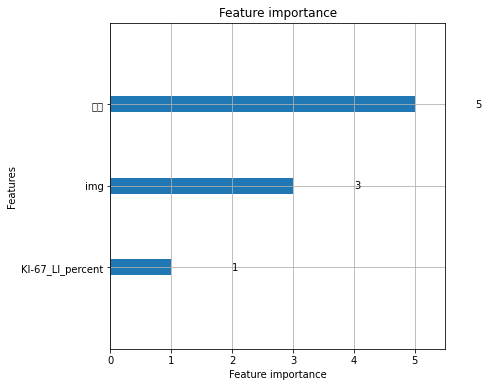

In [27]:
from lightgbm import plot_importance

f, ax = plt.subplots(figsize = (6,6))
plot_importance(lgbm_tree , max_num_features=23, ax= ax)

In [28]:
preds = xgb_tree.predict(val_df)

get_eval(val_labels , preds)

오차 행렬: 
 [[68 29]
 [44 59]]
정확도: 0.635
정밀도: 0.6704545454545454
재현률: 0.5728155339805825
F1: 0.6178010471204188
AUC: 0.636923230907817


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

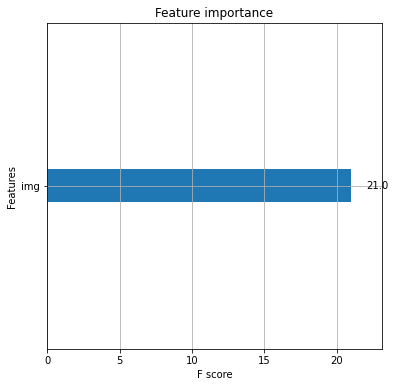

In [29]:
from xgboost import plot_importance

f, ax = plt.subplots(figsize = (6,6))
plot_importance(xgb_tree, max_num_features=23, ax= ax)

In [30]:
test_preds = lgbm_tree.predict(test_df)

In [31]:
test_preds = xgb_tree.predict(test_df)

In [32]:
test_preds

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0])

In [33]:
submit = pd.read_csv('C:/Users/sanda/Desktop/dacon/sample_submission.csv')

In [34]:
submit['N_category'] = test_preds
submit.to_csv('./submit.csv', index=False)

In [35]:
submit.head(10)

,ID,N_category
0,BC_01_0011,1
1,BC_01_0220,0
2,BC_01_0233,0
3,BC_01_0258,1
4,BC_01_0260,1
5,BC_01_0266,1
6,BC_01_0269,1
7,BC_01_0272,1
8,BC_01_0275,0
9,BC_01_0278,1
